# Proximal Policy Optimization


## Introduction

This code example solves the CartPole-v0 environment using a Proximal Policy Optimization (PPO) agent.


### Proximal Policy Optimization

PPO is a policy gradient method and can be used for environments with either discrete or continuous action spaces.
It trains a stochastic policy in an on-policy way. Also, it utilizes the actor critic method. The actor maps the
observation to an action and the critic gives an expectation of the rewards of the agent for the observation given.
Firstly, it collects a set of trajectories for each epoch by sampling from the latest version of the stochastic policy.
Then, the rewards-to-go and the advantage estimates are computed in order to update the policy and fit the value function.
The policy is updated via a stochastic gradient ascent optimizer, while the value function is fitted via some gradient descent algorithm.
This procedure is applied for many epochs until the environment is solved.

![Algorithm](https://i.imgur.com/rd5tda1.png)

- [PPO Original Paper](https://arxiv.org/pdf/1707.06347.pdf)
- [OpenAI Spinning Up docs - PPO](https://spinningup.openai.com/en/latest/algorithms/ppo.html)

### Note

This code example uses Keras and Tensorflow v2. It is based on the PPO Original Paper,
the OpenAI's Spinning Up docs for PPO, and the OpenAI's Spinning Up implementation of PPO using Tensorflow v1.

[OpenAI Spinning Up Github - PPO](https://github.com/openai/spinningup/blob/master/spinup/algos/tf1/ppo/ppo.py)

## Libraries

For this example the following libraries are used:

1. `numpy` for n-dimensional arrays
2. `tensorflow` and `keras` for building the deep RL PPO agent
3. `gym` for getting everything we need about the environment
4. `scipy.signal` for calculating the discounted cumulative sums of vectors

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import gym
import scipy.signal
import time
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import tqdm
%matplotlib inline
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [45]:
%run utils.ipynb
%run torque_dynamics.ipynb
sat.L_p

array([[ 0.   ,  0.251,  0.   ],
       [-0.384,  0.   ,  0.   ],
       [ 0.   ,  1.25 ,  0.   ]])

## Hyperparameters

In [4]:
# Hyperparameters of the PPO algorithm
steps_per_epoch = 500
epochs = 1000
gamma = 0.99
clip_ratio = 0.2
policy_learning_rate = 3e-4
value_function_learning_rate = 1e-3
train_policy_iterations = 80
train_value_iterations = 80
lam = 0.95
target_kl = 0.01
hidden_sizes = (400, 300)

# True if you want to render the environment
render = False

## Physics

In [5]:
def gravity_gradient_torque(quat, inertia_tensor, mean_motion):
    Ae3 = rotate_vec_with_quat(quat, np.array([0., 0., 1.]))

    return 3. * mean_motion ** 2. * cross_product(Ae3, inertia_tensor.dot(Ae3))    


def rhs(t, x, sat, action):

    quat = x[:4] / np.linalg.norm(x[:4])
    omega = x[4:7]
    h = x[7:10]
     
    omega_rel = omega - rotate_vec_with_quat(quat, np.array([0., sat.mean_motion, 0.]))    
        
    trq_gg = gravity_gradient_torque(quat, sat.J, sat.mean_motion)

    x_dot = np.zeros(16)
    omega_dot_rigid = trq_gg + action - cross_product(omega, sat.J.dot(omega) + h)
    eta_dot_flex = sat.D.dot(x[13:]) + sat.K.dot(x[10:13])

    x_dot[0] = -0.5 * quat[1:].dot(omega_rel)
    x_dot[1:4] = 0.5 * (quat[0] * omega_rel + cross_product(quat[1:], omega_rel))
    tmp = omega_dot_rigid + (sat.L_p.T).dot(eta_dot_flex)
    x_dot[4:7] = sat.Aom.dot(sat.J_inv).dot(tmp)
    x_dot[7:10] = - action
    x_dot[10:13] = x[13:]
    x_dot[13:] = - sat.Aeta.dot(eta_dot_flex + sat.L_p.dot(sat.J_inv).dot(omega_dot_rigid))
        
    return x_dot

## Initializations

In [6]:
# Initialize the environment and get the dimensionality of the
# observation space and the number of possible actions
env = TorqueDynamics(0.1, np.array([1, 0, 0, 0]), 16)
observation_dimensions = env.observation_space.shape[0]
num_actions = env.action_space.shape[0]

# Initialize the buffer
buffer = Buffer(observation_dimensions, steps_per_epoch)

# Initialize the actor and the critic as keras models
observation_input = keras.Input(shape=(observation_dimensions,), dtype=tf.float32)
logits = mlp(observation_input, list(hidden_sizes) + [num_actions], tf.nn.relu, None)
actor = keras.Model(inputs=observation_input, outputs=logits)
value = tf.squeeze(
    mlp(observation_input, list(hidden_sizes) + [1], tf.nn.relu, None), axis=1
)
critic = keras.Model(inputs=observation_input, outputs=value)

# Initialize the policy and the value function optimizers
policy_optimizer = keras.optimizers.Adam(learning_rate=policy_learning_rate)
value_optimizer = keras.optimizers.Adam(learning_rate=value_function_learning_rate)



## Train

In [46]:
%%notify
print('Accounting for the gravity')
iterations = 20
obs_shape = 16
tries = 10

for i in tqdm.tqdm(range(tries)):
  print(f'Run #{i}.')
  mean_ret = train(iterations, obs_shape)
  mean_ret = np.min(mean_ret)
  print(f'Current batch mean is {mean_ret}')
  print('-'*10)
  if mean_ret > 5000 and reward_thresh > 0.004:
    reward_thresh *= 0.5# - 3*(mean_ret - 1000)/40000 # linear from (1000, 0.8) to (5000, 0.5)
  

Accounting for the gravity


  0%|          | 0/10 [00:00<?, ?it/s]

Run #0.
starting training with 20 epochs
 Epoch: 1. Mean Return: 2180.561180999854. Mean Length: 500.0
 Epoch: 2. Mean Return: 1947.0759431688346. Mean Length: 500.0
 Epoch: 3. Mean Return: 1190.8140279030613. Mean Length: 500.0
 Epoch: 4. Mean Return: 904.046165519125. Mean Length: 500.0
 Epoch: 5. Mean Return: 3377.6329721411944. Mean Length: 500.0
 Epoch: 6. Mean Return: 688.2450384292969. Mean Length: 500.0
 Epoch: 7. Mean Return: 1147.9381949270155. Mean Length: 500.0
 Epoch: 8. Mean Return: 870.3738209930178. Mean Length: 500.0
 Epoch: 9. Mean Return: 1120.6571068094377. Mean Length: 500.0
 Epoch: 10. Mean Return: 1092.8530237950877. Mean Length: 500.0
 Epoch: 11. Mean Return: 813.9230719625187. Mean Length: 500.0
 Epoch: 12. Mean Return: 989.3583147593222. Mean Length: 500.0
 Epoch: 13. Mean Return: 892.2426482727966. Mean Length: 500.0
 Epoch: 14. Mean Return: 713.9436453198273. Mean Length: 500.0
 Epoch: 15. Mean Return: 1478.4560442644506. Mean Length: 500.0
 Epoch: 16. Mean 

 10%|█         | 1/10 [01:30<13:35, 90.57s/it]

 Epoch: 20. Mean Return: 2279.1496762397624. Mean Length: 500.0
Current batch mean is 688.2450384292969
----------
Run #1.
starting training with 20 epochs
 Epoch: 1. Mean Return: 2164.088976007844. Mean Length: 500.0
 Epoch: 2. Mean Return: 814.0703873411271. Mean Length: 500.0
 Epoch: 3. Mean Return: 1772.3535408939833. Mean Length: 500.0
 Epoch: 4. Mean Return: 2410.428441654435. Mean Length: 500.0
 Epoch: 5. Mean Return: 1537.7338331937715. Mean Length: 500.0
 Epoch: 6. Mean Return: 2732.1368467285824. Mean Length: 500.0
 Epoch: 7. Mean Return: 2865.397849566833. Mean Length: 500.0
 Epoch: 8. Mean Return: 2023.334164160105. Mean Length: 500.0
 Epoch: 9. Mean Return: 2667.6273094759913. Mean Length: 500.0
 Epoch: 10. Mean Return: 3392.5538590389906. Mean Length: 500.0
 Epoch: 11. Mean Return: 1061.7307455361306. Mean Length: 500.0
 Epoch: 12. Mean Return: 2644.37388154946. Mean Length: 500.0
 Epoch: 13. Mean Return: 1890.629015010792. Mean Length: 500.0
 Epoch: 14. Mean Return: 3033

 20%|██        | 2/10 [03:08<12:40, 95.08s/it]

 Epoch: 20. Mean Return: 2247.1131342746767. Mean Length: 500.0
Current batch mean is 814.0703873411271
----------
Run #2.
starting training with 20 epochs
 Epoch: 1. Mean Return: 2018.5765788167457. Mean Length: 500.0
 Epoch: 2. Mean Return: 1261.5567254490443. Mean Length: 500.0
 Epoch: 3. Mean Return: 1731.3840630918278. Mean Length: 500.0
 Epoch: 4. Mean Return: 1910.3432130474457. Mean Length: 500.0
 Epoch: 5. Mean Return: 3033.4270402415036. Mean Length: 500.0
 Epoch: 6. Mean Return: 2033.4084044015708. Mean Length: 500.0
 Epoch: 7. Mean Return: 3244.9802412286112. Mean Length: 500.0
 Epoch: 8. Mean Return: 2288.7420508488053. Mean Length: 500.0
 Epoch: 9. Mean Return: 1750.7527050704757. Mean Length: 500.0
 Epoch: 10. Mean Return: 908.6025433499648. Mean Length: 500.0
 Epoch: 11. Mean Return: 2660.62795196973. Mean Length: 500.0
 Epoch: 12. Mean Return: 2253.4665375097993. Mean Length: 500.0
 Epoch: 13. Mean Return: 3100.7118528315827. Mean Length: 500.0
 Epoch: 14. Mean Return:

 30%|███       | 3/10 [04:47<11:15, 96.56s/it]

 Epoch: 20. Mean Return: 779.2597362049678. Mean Length: 500.0
Current batch mean is 779.2597362049678
----------
Run #3.
starting training with 20 epochs
 Epoch: 1. Mean Return: 2726.222656614631. Mean Length: 500.0
 Epoch: 2. Mean Return: 3480.739247007913. Mean Length: 500.0
 Epoch: 3. Mean Return: 1102.951771066528. Mean Length: 500.0
 Epoch: 4. Mean Return: 2217.3268760514707. Mean Length: 500.0
 Epoch: 5. Mean Return: 871.2616737072462. Mean Length: 500.0
 Epoch: 6. Mean Return: 1730.6111906527553. Mean Length: 500.0
 Epoch: 7. Mean Return: 2715.3968542873263. Mean Length: 500.0
 Epoch: 8. Mean Return: 2317.0021531548787. Mean Length: 500.0
 Epoch: 9. Mean Return: 772.2959305369617. Mean Length: 500.0
 Epoch: 10. Mean Return: 1020.401127480738. Mean Length: 500.0
 Epoch: 11. Mean Return: 2417.7428342523854. Mean Length: 500.0
 Epoch: 12. Mean Return: 1697.7932865322234. Mean Length: 500.0
 Epoch: 13. Mean Return: 2031.8984425768137. Mean Length: 500.0
 Epoch: 14. Mean Return: 178

 40%|████      | 4/10 [06:25<09:44, 97.42s/it]

 Epoch: 20. Mean Return: 2331.781059281292. Mean Length: 500.0
Current batch mean is 772.2959305369617
----------
Run #4.
starting training with 20 epochs
 Epoch: 1. Mean Return: 3101.6718602619044. Mean Length: 500.0
 Epoch: 2. Mean Return: 1410.5240881914224. Mean Length: 500.0
 Epoch: 3. Mean Return: 2596.1026574080047. Mean Length: 500.0
 Epoch: 4. Mean Return: 919.391034287223. Mean Length: 500.0
 Epoch: 5. Mean Return: 1603.1338839325954. Mean Length: 500.0
 Epoch: 6. Mean Return: 2283.358480947302. Mean Length: 500.0
 Epoch: 7. Mean Return: 2006.0838383491841. Mean Length: 500.0
 Epoch: 8. Mean Return: 2068.928207426947. Mean Length: 500.0
 Epoch: 9. Mean Return: 2559.3914629417277. Mean Length: 500.0
 Epoch: 10. Mean Return: 1880.195362587171. Mean Length: 500.0
 Epoch: 11. Mean Return: 2773.865855171018. Mean Length: 500.0
 Epoch: 12. Mean Return: 2018.737832813228. Mean Length: 500.0
 Epoch: 13. Mean Return: 2728.9530617167134. Mean Length: 500.0
 Epoch: 14. Mean Return: 2141

 50%|█████     | 5/10 [08:04<08:08, 97.73s/it]

 Epoch: 20. Mean Return: 853.7644347516732. Mean Length: 500.0
Current batch mean is 853.7644347516732
----------
Run #5.
starting training with 20 epochs
 Epoch: 1. Mean Return: 718.2989365247349. Mean Length: 500.0
 Epoch: 2. Mean Return: 1719.4248736466377. Mean Length: 500.0
 Epoch: 3. Mean Return: 2376.0836622263078. Mean Length: 500.0
 Epoch: 4. Mean Return: 2243.6575371993913. Mean Length: 500.0
 Epoch: 5. Mean Return: 2099.122803225809. Mean Length: 500.0
 Epoch: 6. Mean Return: 2267.095900308419. Mean Length: 500.0
 Epoch: 7. Mean Return: 716.7124595645017. Mean Length: 500.0
 Epoch: 8. Mean Return: 1676.9905609192997. Mean Length: 500.0
 Epoch: 9. Mean Return: 2404.3128787324486. Mean Length: 500.0
 Epoch: 10. Mean Return: 1514.1435790917442. Mean Length: 500.0
 Epoch: 11. Mean Return: 2067.6053598080425. Mean Length: 500.0
 Epoch: 12. Mean Return: 938.1859095131523. Mean Length: 500.0
 Epoch: 13. Mean Return: 2512.040590602983. Mean Length: 500.0
 Epoch: 14. Mean Return: 201

 60%|██████    | 6/10 [09:43<06:32, 98.20s/it]

 Epoch: 20. Mean Return: 566.3367607221464. Mean Length: 500.0
Current batch mean is 559.6958402111619
----------
Run #6.
starting training with 20 epochs
 Epoch: 1. Mean Return: 2940.7600719851066. Mean Length: 500.0
 Epoch: 2. Mean Return: 2715.7002773564427. Mean Length: 500.0
 Epoch: 3. Mean Return: 1620.2100789751175. Mean Length: 500.0
 Epoch: 4. Mean Return: 1289.454223521816. Mean Length: 500.0
 Epoch: 5. Mean Return: 2453.4182810450197. Mean Length: 500.0
 Epoch: 6. Mean Return: 2197.7731582557. Mean Length: 500.0
 Epoch: 7. Mean Return: 920.9693148936395. Mean Length: 500.0
 Epoch: 8. Mean Return: 3052.8015441985312. Mean Length: 500.0
 Epoch: 9. Mean Return: 2181.4498798372642. Mean Length: 500.0
 Epoch: 10. Mean Return: 885.6092157957595. Mean Length: 500.0
 Epoch: 11. Mean Return: 2123.115486000655. Mean Length: 500.0
 Epoch: 12. Mean Return: 667.95571598846. Mean Length: 500.0
 Epoch: 13. Mean Return: 1378.1811719732. Mean Length: 500.0
 Epoch: 14. Mean Return: 2637.17160

 70%|███████   | 7/10 [11:24<04:57, 99.24s/it]

 Epoch: 20. Mean Return: 1505.5354650884335. Mean Length: 500.0
Current batch mean is 667.95571598846
----------
Run #7.
starting training with 20 epochs
 Epoch: 1. Mean Return: 2159.5436194487816. Mean Length: 500.0
 Epoch: 2. Mean Return: 2568.4643996780533. Mean Length: 500.0
 Epoch: 3. Mean Return: 811.085865739933. Mean Length: 500.0
 Epoch: 4. Mean Return: 2830.7309540850447. Mean Length: 500.0
 Epoch: 5. Mean Return: 700.8519138926952. Mean Length: 500.0
 Epoch: 6. Mean Return: 1376.530731992821. Mean Length: 500.0
 Epoch: 7. Mean Return: 2267.1835971461683. Mean Length: 500.0
 Epoch: 8. Mean Return: 2214.4983782246786. Mean Length: 500.0
 Epoch: 9. Mean Return: 2592.8071364646494. Mean Length: 500.0
 Epoch: 10. Mean Return: 2060.0403543934653. Mean Length: 500.0
 Epoch: 11. Mean Return: 2136.6035200301476. Mean Length: 500.0
 Epoch: 12. Mean Return: 2271.087371423634. Mean Length: 500.0
 Epoch: 13. Mean Return: 2913.2396120600793. Mean Length: 500.0
 Epoch: 14. Mean Return: 168

 80%|████████  | 8/10 [13:19<03:28, 104.33s/it]

 Epoch: 20. Mean Return: 887.3046827557909. Mean Length: 500.0
Current batch mean is 700.8519138926952
----------
Run #8.
starting training with 20 epochs
 Epoch: 1. Mean Return: 2777.825362901594. Mean Length: 500.0
 Epoch: 2. Mean Return: 2821.5242958968893. Mean Length: 500.0
 Epoch: 3. Mean Return: 1804.2266294416754. Mean Length: 500.0
 Epoch: 4. Mean Return: 3263.6790630176097. Mean Length: 500.0
 Epoch: 5. Mean Return: 2588.6718628138083. Mean Length: 500.0
 Epoch: 6. Mean Return: 1937.817903789368. Mean Length: 500.0
 Epoch: 7. Mean Return: 958.5086580138948. Mean Length: 500.0
 Epoch: 8. Mean Return: 691.7266651186841. Mean Length: 500.0
 Epoch: 9. Mean Return: 2999.0789722708046. Mean Length: 500.0
 Epoch: 10. Mean Return: 1870.1110813760704. Mean Length: 500.0
 Epoch: 11. Mean Return: 969.6067362707536. Mean Length: 500.0
 Epoch: 12. Mean Return: 830.4959496410634. Mean Length: 500.0
 Epoch: 13. Mean Return: 895.9074363709742. Mean Length: 500.0
 Epoch: 14. Mean Return: 2371

 90%|█████████ | 9/10 [14:59<01:42, 102.82s/it]

 Epoch: 20. Mean Return: 857.8789446111122. Mean Length: 500.0
Current batch mean is 554.214958435517
----------
Run #9.
starting training with 20 epochs
 Epoch: 1. Mean Return: 842.1672811850648. Mean Length: 500.0
 Epoch: 2. Mean Return: 681.1685905189166. Mean Length: 500.0
 Epoch: 3. Mean Return: 815.0683874940779. Mean Length: 500.0
 Epoch: 4. Mean Return: 1143.9538946592843. Mean Length: 500.0
 Epoch: 5. Mean Return: 1584.1017512244246. Mean Length: 500.0
 Epoch: 6. Mean Return: 1115.1044245144155. Mean Length: 500.0
 Epoch: 7. Mean Return: 1365.5472569570593. Mean Length: 500.0
 Epoch: 8. Mean Return: 1018.2446881322052. Mean Length: 500.0
 Epoch: 9. Mean Return: 985.510915923838. Mean Length: 500.0
 Epoch: 10. Mean Return: 1225.896209197363. Mean Length: 500.0
 Epoch: 11. Mean Return: 1181.3050143809644. Mean Length: 500.0
 Epoch: 12. Mean Return: 1905.858624091165. Mean Length: 500.0
 Epoch: 13. Mean Return: 725.05310157008. Mean Length: 500.0
 Epoch: 14. Mean Return: 983.9773

100%|██████████| 10/10 [16:40<00:00, 100.04s/it]

 Epoch: 20. Mean Return: 3053.619400590737. Mean Length: 500.0
Current batch mean is 681.1685905189166
----------


<IPython.core.display.Javascript object>

## Display results

In [47]:
# %%notify
env = TorqueDynamics(0.1, np.array([1, 0, 0, 0]), 16)
observation = env.reset()
episode_return = 0
# Iterate over the steps of each epoch
for t in range(steps_per_epoch*2):
    if render:
        env.render()

    # Get the logits, action, and take one step in the environment
    observation = observation.reshape(1, -1)
    logits, action = sample_action(observation)
    #action = [env.action_space.shape[0]//2]
    #print(type(action[0].numpy()))
    observation_new, reward, done, info = env.step(action[0].numpy())
    episode_return += reward

    # Update the observation
    observation = observation_new
print(episode_return)

3029.589752288632


means:
roll=24.575817785104	pitch=55.524261684793906	yaw=21.91918691796639
std:
roll=16.348147381743964	pitch=9.45748698893209	yaw=8.11173573491622


C:\Users\Алексей\AppData\Local\Temp\ipykernel_328\3660080882.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


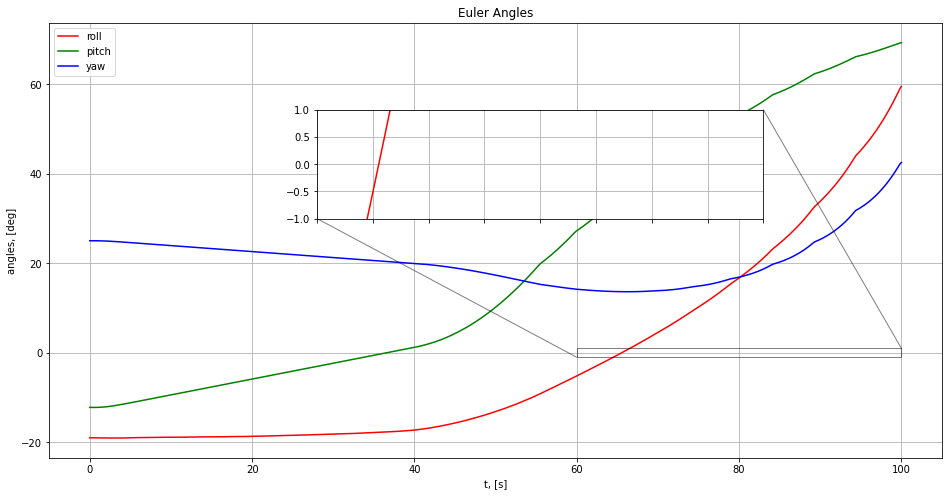

In [48]:
x = np.array(info['x'])
t = np.array(info['t'])
roll, pitch, yaw = quat2rpy_deg(x[:,0], x[:,1], x[:,2], x[:,3])
size = roll.shape[0]//3
print(f'means:\nroll={np.mean(roll[-size:])}\tpitch={np.mean(pitch[-size:])}\tyaw={np.mean(yaw[-size:])}\n\
std:\nroll={np.std(roll[-size:])}\tpitch={np.std(pitch[-size:])}\tyaw={np.std(yaw[-size:])}')

plot_euler_angles(t, roll, pitch, yaw, filename='angles2.pdf', inset=True)

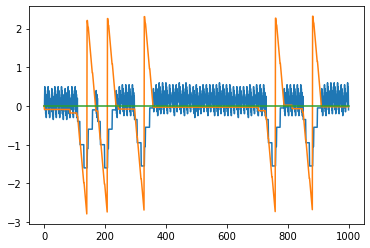

In [44]:
plt.plot(x[:, 7:10])

In [ ]:
start = np.array([np.cos(np.pi/2),0,0,np.sin(np.pi/2),0,0,0,0,0,0])

In [ ]:
roll, pitch, yaw = quat2rpy_deg(x[:,0], x[:,1], x[:,2], x[:,3])
   
fig1 = plt.figure(figsize=(16,8))
ax1 = fig1.add_subplot(2,2,1)

ax1.set_title("Euler Angles")
ax1.plot(t, roll, label = 'roll', color = 'red')
ax1.plot(t, pitch, label = 'pitch', color = 'green')
ax1.plot(t, yaw, label = 'yaw', color = 'blue')
ax1.set_ylabel(r'angles, [deg]')
ax1.set_xlabel(r't, [s]')
ax1.grid(True)
ax1.legend()

ax2 = fig1.add_subplot(2,2,2)

ax2.set_title("Angular Velocity")
ax2.plot(t, x[:,4], label = '$\omega_x$', color = 'red')
ax2.plot(t, x[:,5], label = '$\omega_y$', color = 'green')
ax2.plot(t, x[:,6], label = '$\omega_z$', color = 'blue')
ax2.set_ylabel(r'angular velocity, [rad/s]')
ax2.set_xlabel(r't, [s]')
ax2.grid(True)
ax2.legend()

ax2 = fig1.add_subplot(2,2,3)

ax2.set_title("RW angular momentum")
ax2.plot(t, x[:,7], label = '$h_x$', color = 'red')
ax2.plot(t, x[:,8], label = '$h_y$', color = 'green')
ax2.plot(t, x[:,9], label = '$h_z$', color = 'blue')
ax2.set_ylabel(r'h, [Nms]')
ax2.set_xlabel(r't, [s]')
ax2.grid(True)
ax2.legend()

plt.tight_layout()

## Saving the weights

In [ ]:
actor_config = actor.get_config()
actor_weights = actor.get_weights()
critic_config = critic.get_config()
critic_weights = critic.get_weights()
import pickle
name = f'configs_weights_sin{iterations} {reward_thresh}.pickle'
with open(name, 'wb') as f:
  pickle.dump((actor_config, actor_weights, critic_config, critic_weights), f)

## Importing the weights

In [7]:
import pickle
# iterations = 1500
# reward_thresh = 0.0043
name = f'data/configs_weights.pickle'
with open(name, 'rb') as f:
  something = pickle.load(f)

actor_config, actor_weights ,critic_config, critic_weights = something
actor = keras.Model.from_config(actor_config)
actor.set_weights(actor_weights)
critic = keras.Model.from_config(critic_config)
critic.set_weights(critic_weights)